In [3]:
pip install mplfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import plotly.express as px
import numpy as np
import yfinance as yf
import os
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
import os
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# File path
file_path = "datasets/TCS_stock_history.csv"

# Load existing data or create a new one
if os.path.exists(file_path):
    tcs_stock_history_data = pd.read_csv(file_path, parse_dates=["Date"])
else:
    tcs_stock_history_data = pd.DataFrame(columns=["Date", "Open", "High", "Low", "Close", "Volume"])

# Get the last available date in your dataset
if not tcs_stock_history_data.empty:
    last_date = tcs_stock_history_data["Date"].max().date()
else:
    # If no data exists, fetch from some default past date
    last_date = datetime.now().date() - timedelta(days=30)

# Define the end date as yesterday (to avoid incomplete data)
end_date = datetime.now().date() - timedelta(days=1)

# Fetch historical data from last_date + 1 to end_date
start_date = last_date + timedelta(days=1)
if start_date > end_date:
    print("✅ Data is already up-to-date.")
else:
    tcs = yf.Ticker("TCS.NS")
    new_data = tcs.history(start=start_date, end=end_date + timedelta(days=1))  # include end_date
    if not new_data.empty:
        new_data.reset_index(inplace=True)
        new_data = new_data[["Date", "Open", "High", "Low", "Close", "Volume"]]
        new_data["Date"] = new_data["Date"].dt.date  # Keep as date format

        # Filter out dates already present
        existing_dates = set(tcs_stock_history_data["Date"].dt.date)
        new_data = new_data[~new_data["Date"].isin(existing_dates)]

        if not new_data.empty:
            tcs_stock_history_data = pd.concat([tcs_stock_history_data, new_data], ignore_index=True)
            tcs_stock_history_data.sort_values("Date", inplace=True)
            tcs_stock_history_data.to_csv(file_path, index=False)
            print(f"✅ Added {len(new_data)} new records from {start_date} to {end_date}.")
        else:
            print("🔍 No new data to add. Everything is already up-to-date.")
    else:
        print("⚠️ No historical stock data available for the requested range.")


🔍 No new data to add. Everything is already up-to-date.


In [6]:
tcs_stock_history_data = pd.read_csv('datasets/TCS_stock_history.csv')
tcs_stock_history_data['Date'] = pd.to_datetime(tcs_stock_history_data['Date'], errors='coerce')
tcs_stock_history_data.sort_values(by = 'Date', inplace = True)
tcs_stock_history_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0
...,...,...,...,...,...,...,...,...
5331,2025-04-07,3100.000000,3291.399902,3056.050049,3274.050049,6623955,NaN,NaN
5332,2025-04-08,3302.050049,3349.000000,3255.300049,3292.949951,5557558,NaN,NaN
5333,2025-04-09,3260.550049,3270.000000,3212.050049,3246.600098,2990265,NaN,NaN
5334,2025-04-11,3289.550049,3298.949951,3206.000000,3231.500000,7108961,NaN,NaN


In [7]:
print(tcs_stock_history_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5336 entries, 0 to 5335
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5336 non-null   datetime64[ns]
 1   Open          5336 non-null   float64       
 2   High          5336 non-null   float64       
 3   Low           5336 non-null   float64       
 4   Close         5336 non-null   float64       
 5   Volume        5336 non-null   int64         
 6   Dividends     4463 non-null   float64       
 7   Stock Splits  4463 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 375.2 KB
None


In [8]:
check_null_values = tcs_stock_history_data.isnull().sum()
if check_null_values is True:
  print("Null values are present")
  print(check_null_values)
else:
  print("Null values are not present \n")
  print(check_null_values)

Null values are not present 

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
Dividends       873
Stock Splits    873
dtype: int64


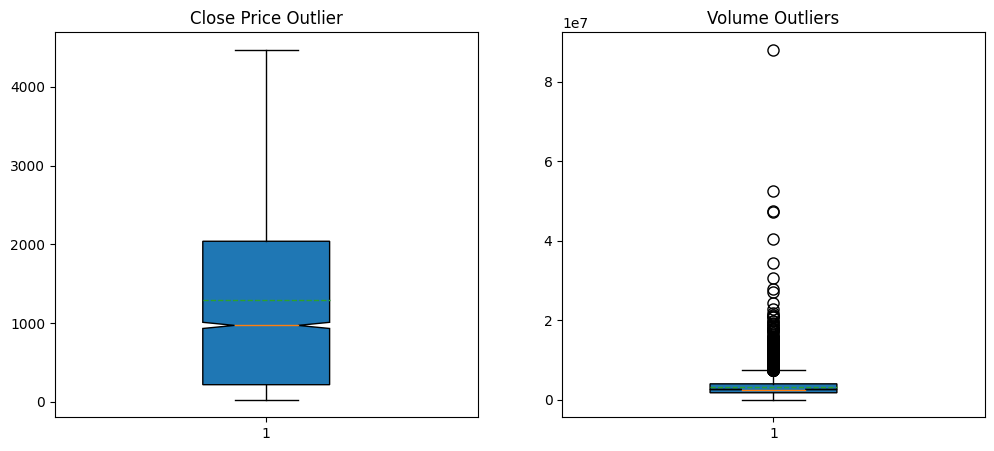

In [9]:
plt.figure(figsize= (12, 5))
plt.subplot(1,2,1)
plt.boxplot(tcs_stock_history_data['Close'], patch_artist=True, notch=True, widths=0.3, meanline=True, showmeans=True,
            flierprops=dict(marker='o', color='red', markersize=8))
plt.title('Close Price Outlier')

plt.subplot(1, 2, 2)
plt.boxplot(tcs_stock_history_data['Volume'], patch_artist=True, notch=True, vert=True, widths=0.3, meanline=True, showmeans=True,
            flierprops=dict(marker='o', color='red', markersize=8))
plt.title('Volume Outliers')
plt.show()

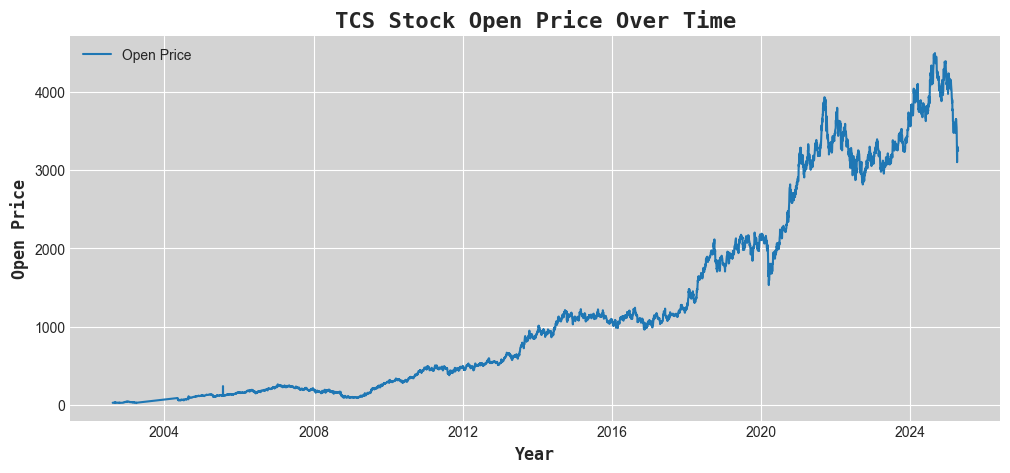

In [10]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize = (12, 5))
plt.gca().set_facecolor('lightgray')
plt.plot(tcs_stock_history_data['Date'], tcs_stock_history_data['Open'], color = '#1f77b4', label = 'Open Price')
plt.xlabel('Year', fontsize=12, fontweight='bold', fontfamily='monospace')
plt.ylabel('Open Price', fontsize=12, fontweight='bold', fontfamily='monospace')
plt.title('TCS Stock Open Price Over Time', fontsize=16, fontweight='bold', fontfamily='monospace')
plt.legend()
plt.show()

In [11]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


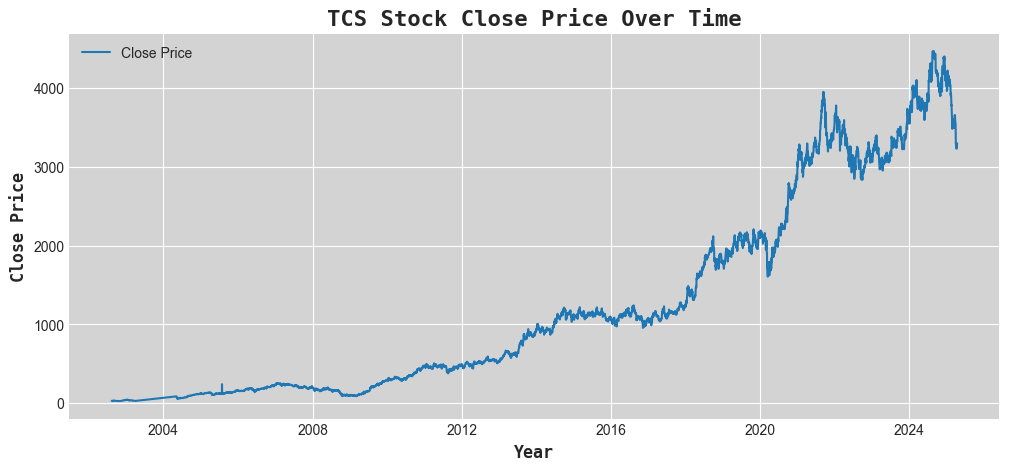

In [12]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize = (12, 5))
plt.gca().set_facecolor('lightgray')
plt.plot(tcs_stock_history_data['Date'], tcs_stock_history_data['Close'], color='#1f77b4', label = 'Close Price')
plt.xlabel('Year', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.ylabel('Close Price', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.title('TCS Stock Close Price Over Time', fontsize = 16, fontweight = 'bold', fontfamily = 'monospace')
plt.legend()
plt.show()

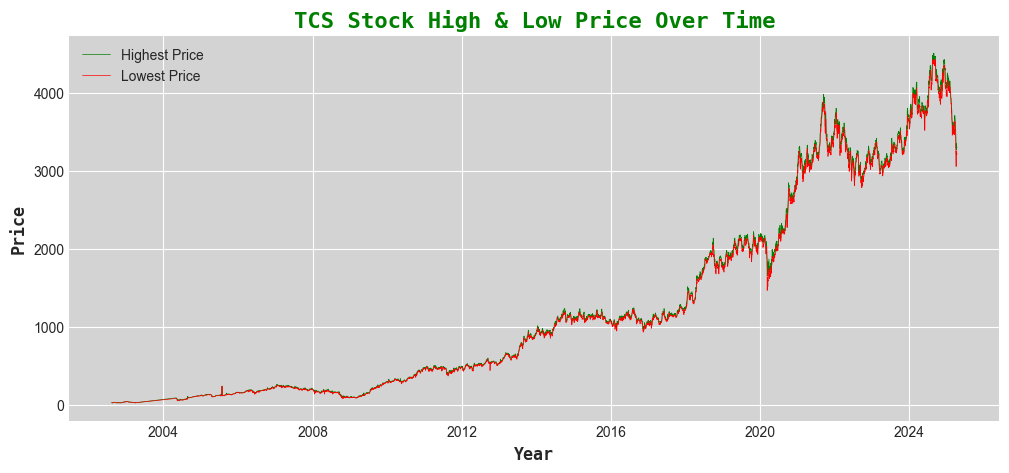

In [13]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize = (12, 5))
plt.gca().set_facecolor('lightgray')
plt.plot(tcs_stock_history_data['Date'], tcs_stock_history_data['High'], color='green', label = 'Highest Price', linewidth = 0.5)
plt.plot(tcs_stock_history_data['Date'], tcs_stock_history_data['Low'], color='red', label = 'Lowest Price', linewidth = 0.5)
plt.xlabel('Year', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.ylabel('Price', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.title('TCS Stock High & Low Price Over Time', fontsize = 16, fontweight = 'bold', fontfamily = 'monospace', color = 'green')
plt.legend()
plt.show()

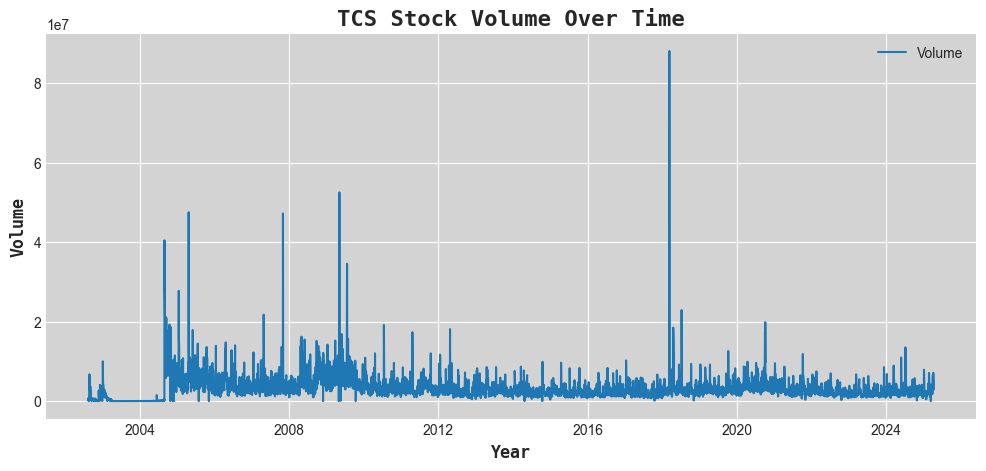

In [14]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize = (12, 5))
plt.gca().set_facecolor('lightgray')
plt.plot(tcs_stock_history_data['Date'], tcs_stock_history_data['Volume'], color='#1f77b4', label = 'Volume')
plt.xlabel('Year', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.ylabel('Volume', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.title('TCS Stock Volume Over Time', fontsize = 16, fontweight = 'bold', fontfamily = 'monospace')
plt.legend()
plt.show()

In [15]:
years = tcs_stock_history_data['Date'].dt.year
volume_per_year = tcs_stock_history_data.groupby(years)['Volume'].sum()
print(volume_per_year)

Date
2002     109051976
2003      72899672
2004     876093896
2005    1495302344
2006     994139844
2007    1065861528
2008    1296917336
2009    1526527402
2010     840244724
2011     817976452
2012     667246580
2013     674954682
2014     578958206
2015     580144728
2016     539221804
2017     548139150
2018     849403971
2019     735316589
2020     999223368
2021     681162182
2022     581528452
2023     473682090
2024     593722800
2025     188263656
Name: Volume, dtype: int64


In [16]:
fig = px.bar(
    x=volume_per_year.index,
    y=volume_per_year.values,
    text=[f"{volume:,}" for volume in volume_per_year],
    labels={'x': 'Years', 'y': 'Stock Volume'},
    color=volume_per_year.values,
    title="TCS Stock Volume Per Year"
)

fig.update_traces(
    textposition='auto',
    hoverinfo="text+y"
)

fig.update_layout(
    xaxis_title="Years",
    yaxis_title="",
    xaxis_tickangle=-45,
    template="plotly_white"
)
fig.show()

In [17]:
#Checking Stock Split Occurrence
filterd_stock_split = tcs_stock_history_data[tcs_stock_history_data['Stock Splits'] > 0]
filterd_stock_split

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
729,2006-07-28,178.257459,184.865564,175.204656,176.048447,3019608,0.375,2.0
1436,2009-06-16,152.041630,156.087616,147.241995,154.362122,4344006,1.250,2.0
3642,2018-05-31,1625.963422,1649.452732,1618.555607,1632.574219,5049371,14.500,2.0


In [18]:
#Volume Moving averages
volume_moving_average = tcs_stock_history_data['Volume'].rolling(window=100).mean()
pd.DataFrame(volume_moving_average)

,Volume
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
5331,2413558.17
5332,2453257.35
5333,2472171.87
5334,2525007.16


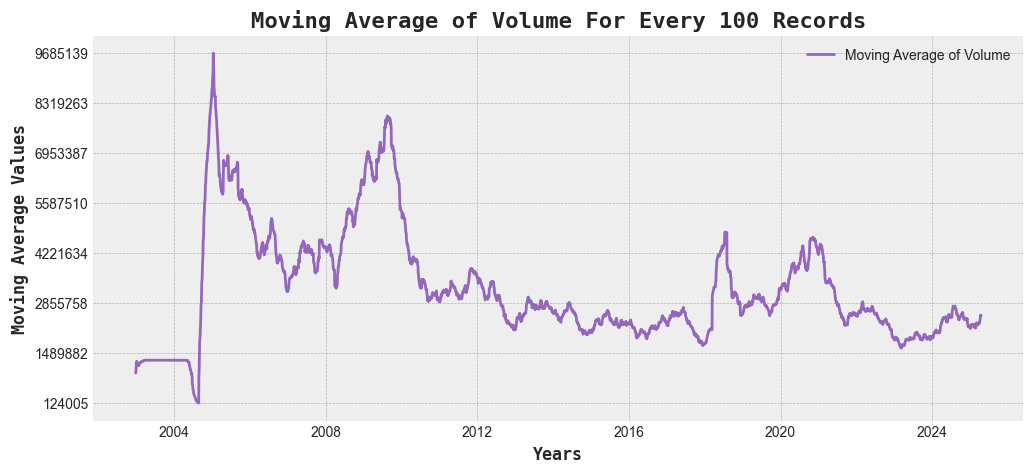

In [19]:
plt.style.use('bmh')
plt.figure(figsize=(12, 5))
plt.plot(tcs_stock_history_data['Date'], volume_moving_average, label = 'Moving Average of Volume', color = '#9467bd')
ytick_values = np.linspace(volume_moving_average.min(), volume_moving_average.max(), num = 8)

plt.xlabel('Years', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.ylabel('Moving Average Values', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.title('Moving Average of Volume For Every 100 Records', fontsize = 16, fontweight = 'bold', fontfamily = 'monospace')
plt.yticks(ytick_values)
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show()

In [20]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [21]:
window_size = 100
MA_Open = tcs_stock_history_data['Open'].rolling(window=window_size).mean()
MA_High = tcs_stock_history_data['High'].rolling(window=window_size).mean()
MA_Low = tcs_stock_history_data['Low'].rolling(window=window_size).mean()
MA_Close = tcs_stock_history_data['Close'].rolling(window=window_size).mean()

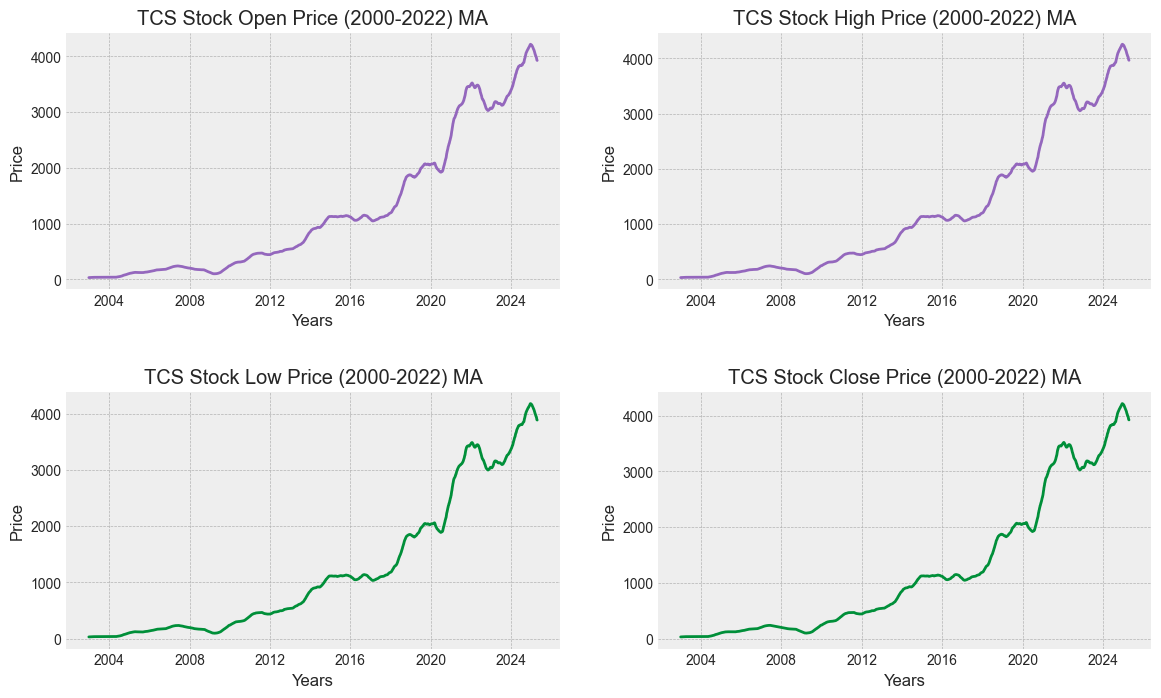

In [22]:
plt.style.use('bmh')
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(tcs_stock_history_data['Date'], MA_Open, color = '#9467bd')
axes[0, 0].set_title("TCS Stock Open Price (2000-2022) MA")
axes[0, 0].set_xlabel("Years")
axes[0, 0].set_ylabel("Price")

axes[0, 1].plot(tcs_stock_history_data['Date'], MA_High, color = '#9467bd')
axes[0, 1].set_title("TCS Stock High Price (2000-2022) MA")
axes[0, 1].set_xlabel("Years")
axes[0, 1].set_ylabel("Price")

axes[1, 0].plot(tcs_stock_history_data['Date'], MA_Low, color = '#008F39')
axes[1, 0].set_title("TCS Stock Low Price (2000-2022) MA")
axes[1, 0].set_xlabel("Years")
axes[1, 0].set_ylabel("Price")

axes[1, 1].plot(tcs_stock_history_data['Date'], MA_Close, color = '#008F39')
axes[1, 1].set_title("TCS Stock Close Price (2000-2022) MA")
axes[1, 1].set_xlabel("Years")
axes[1, 1].set_ylabel("Price")


plt.subplots_adjust(hspace=0.4, wspace=0.2)

plt.show()

In [23]:
tcs_stock_history_data["Date"] = pd.to_datetime(tcs_stock_history_data["Date"])
tcs_stock_history_data.set_index("Date", inplace=True)

In [24]:
data = tcs_stock_history_data[["Close"]].values

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [26]:
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

In [27]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [28]:
seq_length = 60  # Use last 60 days to predict the next day
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [29]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [30]:
# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

In [31]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [32]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [33]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
132/132 [==============================] - 21s 87ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 2/50
132/132 [==============================] - 9s 70ms/step - loss: 3.7229e-04 - val_loss: 7.8367e-04
Epoch 3/50
132/132 [==============================] - 9s 71ms/step - loss: 3.4735e-04 - val_loss: 6.9457e-04
Epoch 4/50
132/132 [==============================] - 9s 71ms/step - loss: 2.7693e-04 - val_loss: 9.8854e-04
Epoch 5/50
132/132 [==============================] - 9s 71ms/step - loss: 2.5647e-04 - val_loss: 6.7869e-04
Epoch 6/50
132/132 [==============================] - 9s 71ms/step - loss: 2.4264e-04 - val_loss: 0.0010
Epoch 7/50
132/132 [==============================] - 9s 71ms/step - loss: 2.4096e-04 - val_loss: 7.0398e-04
Epoch 8/50
132/132 [==============================] - 9s 71ms/step - loss: 2.3890e-04 - val_loss: 8.3358e-04
Epoch 9/50
132/132 [==============================] - 9s 71ms/step - loss: 2.1900e-04 - val_loss: 4.7562e-04
Epoch 10/50
132/132 [=========

In [34]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)  # Convert back to original scale
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

32/32 [==============================] - 3s 23ms/step


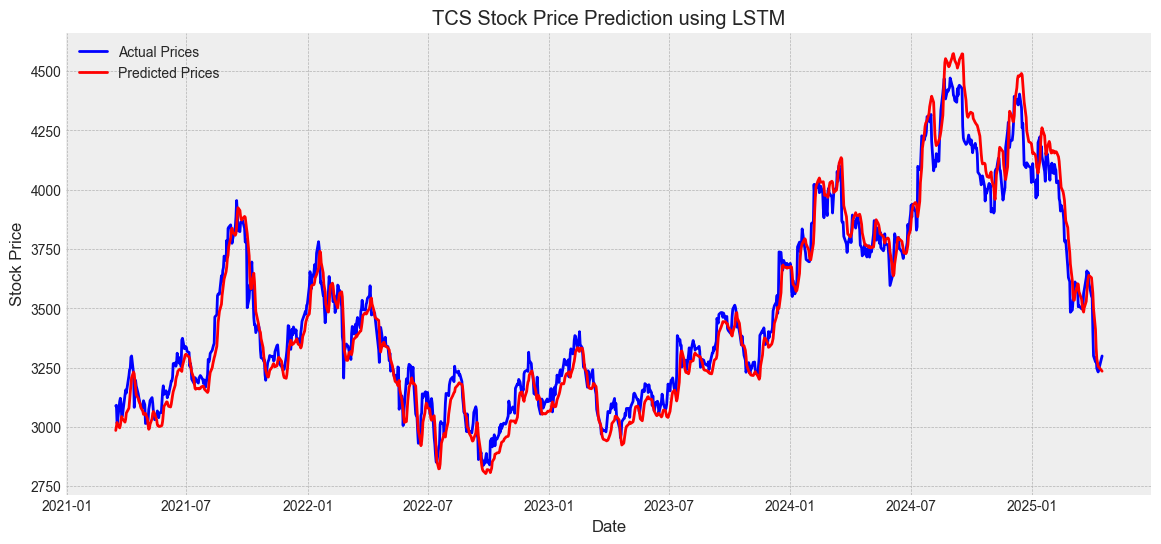

Mean Squared Error: 6682.9414
Mean Absolute Error: 65.0134


In [35]:
plt.figure(figsize=(14, 6))
plt.plot(tcs_stock_history_data.index[train_size + seq_length:], actual, label="Actual Prices", color="blue")
plt.plot(tcs_stock_history_data.index[train_size + seq_length:], predicted, label="Predicted Prices", color="red")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("TCS Stock Price Prediction using LSTM")
plt.legend()
plt.show()

# Print model evaluation metrics
mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

In [36]:
model.save("tcs_lstm_model.h5")